In [14]:
from dotenv import load_dotenv
load_dotenv(dotenv_path="../../.env", override=True)

True

In [15]:
from langchain_openai import ChatOpenAI
model = ChatOpenAI(model="gpt-4.1-mini", temperature=0)

In [16]:
from langgraph.graph import MessagesState
class State(MessagesState):
    context: str

In [17]:
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

def call_model(state: State):
    context = state.get("context", "")
    
    if context:
        system_message = f"Context of the conversation had till now: {context}"
        messages = [SystemMessage(content=system_message)] + state["messages"]
    else:
        messages = state["messages"]
    
    response = model.invoke(messages)
    return {"messages": response}

In [18]:
def contexualize_conversation(state: State):
    context = state.get("context", "")
    if context:
        context_message = (
            f"This is context of the conversation to date: {context}\n\n"
            "Extend the context by taking into account the new messages above: "
        )
    else:
        context_message = "Create a context of the conversation above: "

    messages = state["messages"] + [HumanMessage(content=context_message)]
    response = model.invoke(messages)

    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-3]]
    return {"context": response.content, "messages": delete_messages}

In [19]:
from langgraph.graph import END
from typing_extensions import Literal

def should_continue(state: State) -> Literal ["contexualize_conversation",END]:
    """Return the next node to execute."""
    
    messages = state["messages"]
    if len(messages) > 6:
        return "contexualize_conversation"

    return END

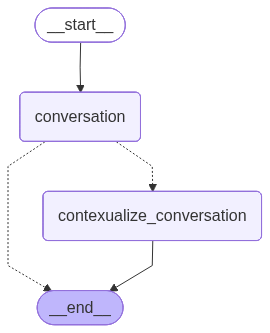

In [20]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START

workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(contexualize_conversation)

workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("contexualize_conversation", END)

memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [21]:
config = {"configurable": {"thread_id": "1"}}

input_message = HumanMessage(content="Hi! I'm Daksh")
output = graph.invoke({"messages": [input_message]}, config)
 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="What's my name?")
output = graph.invoke({"messages": [input_message]}, config)
 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="I like the Cules!")
output = graph.invoke({"messages": [input_message]}, config)
 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Hello Daksh! How can I assist you today?
================================== Ai Message ==================================

Your name is Daksh. How can I help you today?
================================== Ai Message ==================================

That's awesome, Daksh! Being a Cule means you're a fan of FC Barcelona, right? Do you have a favorite player or a memorable match you'd like to talk about?


In [23]:
graph.get_state(config).values.get("context","")

''

In [24]:
input_message = HumanMessage(content="i like Lionel Messi, isn't he their best striker?")
output = graph.invoke({"messages": [input_message]}, config)

for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Absolutely, Daksh! Lionel Messi is widely regarded as one of the greatest footballers of all time and was indeed FC Barcelona's best striker for many years. His incredible skill, vision, and goal-scoring ability made him a legend at the club. Are you following his current career as well?


In [25]:
graph.get_state(config).values.get("context","")

"Sure! Here's a context summary of our conversation:\n\n---\n\n**Context:**  \nDaksh, a fan of FC Barcelona (also known as the Cules), started a conversation expressing his support for the team. He mentioned his admiration for Lionel Messi, recognizing him as the club's best striker. The discussion highlighted Daksh's enthusiasm for football and his interest in one of the sport's greatest players.\n\n---\n\nWould you like me to expand or adjust this context in any way?"